In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.pipeline import Pipeline

In [3]:
mpl.style.use("ggplot")

In [4]:
df = pd.read_csv("Data/Train.csv")
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
df.shape

(8523, 12)

In [6]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [7]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [8]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
df["Item_Fat_Content"] = df["Item_Fat_Content"].replace({"low fat":"Low Fat","LF":"Low Fat","reg":"Regular"})

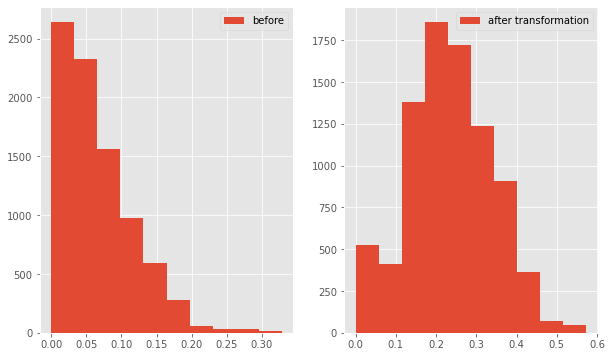

In [10]:
figure,axes = plt.subplots(1,2,figsize=(10,6))
np.sqrt(df.Item_Visibility).hist(ax=axes[1],label="after transformation")
df.Item_Visibility.hist(ax=axes[0],label="before")
axes[0].legend()
axes[1].legend()

In [11]:
df["Item_Visibility"] = np.sqrt(df.Item_Visibility)

In [12]:
# We are taking recency of establishment from 2010 because maximum year is 2009
df["Num_Years"] = 2010 - df["Outlet_Establishment_Year"]

In [13]:
df.drop(["Item_Weight","Outlet_Size","Outlet_Establishment_Year"],axis=1,inplace=True)

In [14]:
df.isna().sum()

Item_Identifier         0
Item_Fat_Content        0
Item_Visibility         0
Item_Type               0
Item_MRP                0
Outlet_Identifier       0
Outlet_Location_Type    0
Outlet_Type             0
Item_Outlet_Sales       0
Num_Years               0
dtype: int64

In [15]:
def outlier_treat(x):
    if (x.dtype=="float") or (x.dtype=="int"):
        x = x.clip(lower = x.quantile(0.01),upper = x.quantile(0.99))
    else:
        x
    return x

In [16]:
df = df.apply(outlier_treat,axis=1)

In [17]:
for feature in df.columns:
    if feature != "Item_Weight":
        print(feature, ": ",df[feature].unique(),"\n",len(df[feature].unique()))

Item_Identifier :  ['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05'] 
 1559
Item_Fat_Content :  ['Low Fat' 'Regular'] 
 2
Item_Visibility :  [0.12667794 0.13884602 0.12946071 ... 0.18758004 0.38107827 0.21184494] 
 7880
Item_Type :  ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood'] 
 16
Item_MRP :  [249.8092  48.2692 141.618  ...  57.5904 214.5218  75.467 ] 
 5938
Outlet_Identifier :  ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019'] 
 10
Outlet_Location_Type :  ['Tier 1' 'Tier 3' 'Tier 2'] 
 3
Outlet_Type :  ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3'] 
 4
Item_Outlet_Sales :  [3735.138   443.4228 2097.27   ... 7182.6504 3608.636  2778.3834] 
 3493
Num_Years :  [11  1 12 23 25  8  3 13  6] 
 9


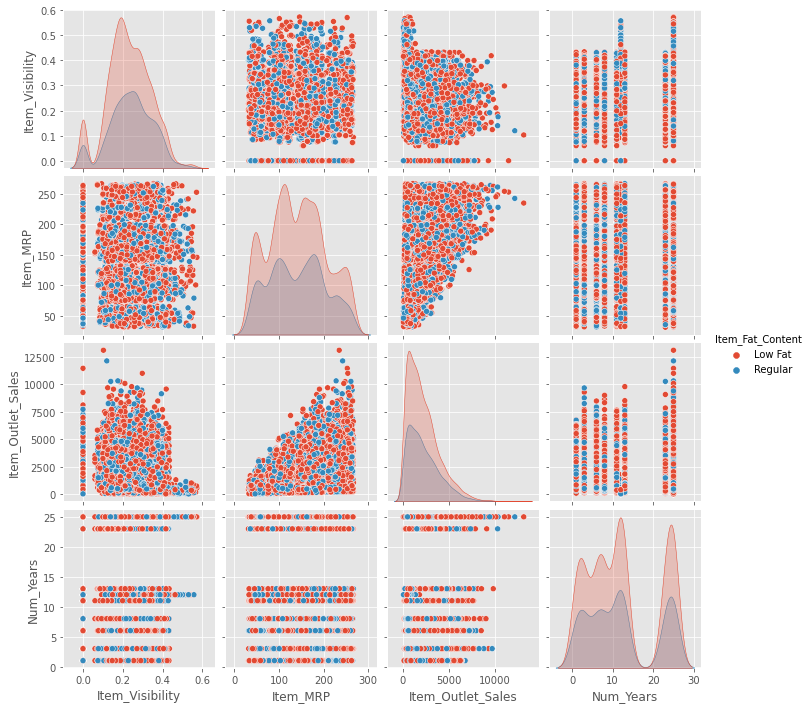

In [18]:
import seaborn as sns
sns.pairplot(df,hue="Item_Fat_Content")

In [19]:
categorical = [feature for feature in df.columns if len(df[feature].unique()) <30 and feature not in ["Num_Years","Outlet_Identifier","Item_Type"]]
categorical_df = df[categorical]

In [20]:
categorical

['Item_Fat_Content', 'Outlet_Location_Type', 'Outlet_Type']

<Figure size 720x432 with 0 Axes>

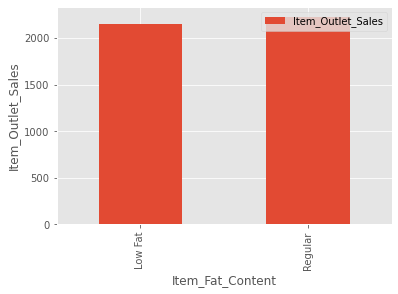

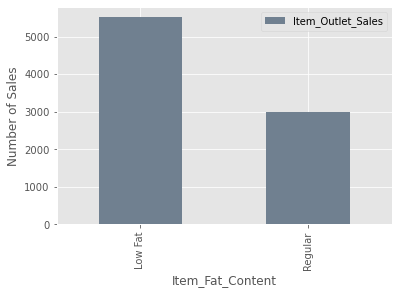

<Figure size 720x432 with 0 Axes>

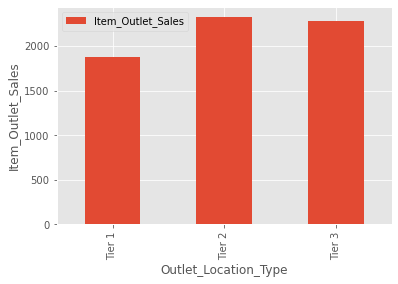

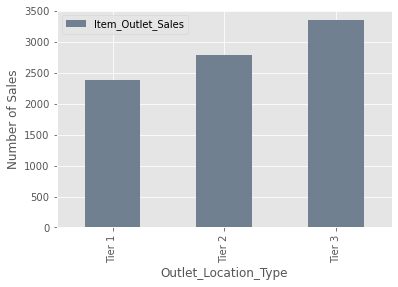

<Figure size 720x432 with 0 Axes>

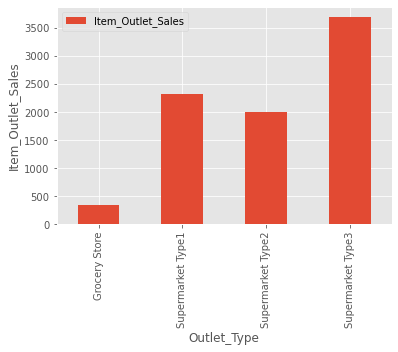

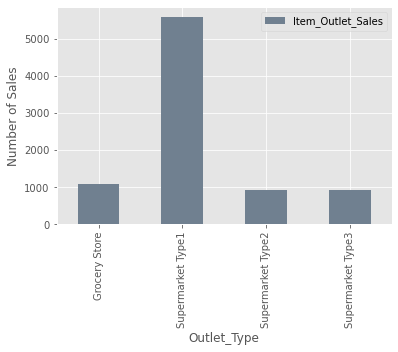

In [21]:
for feature in categorical:
    plt.figure(figsize=(10,6))
    df[[feature,"Item_Outlet_Sales"]].groupby(feature).mean().plot(kind="bar",ylabel="Item_Outlet_Sales")
    df[[feature,"Item_Outlet_Sales"]].groupby(feature).count().plot(kind="bar",ylabel="Number of Sales",color="slategray",label ="Number of Sales")
    plt.show()

In [22]:
numerical = [feature for feature in df.columns if df[feature].dtype!="O"]
numerical_df = df[numerical]

In [23]:
numerical

['Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales', 'Num_Years']

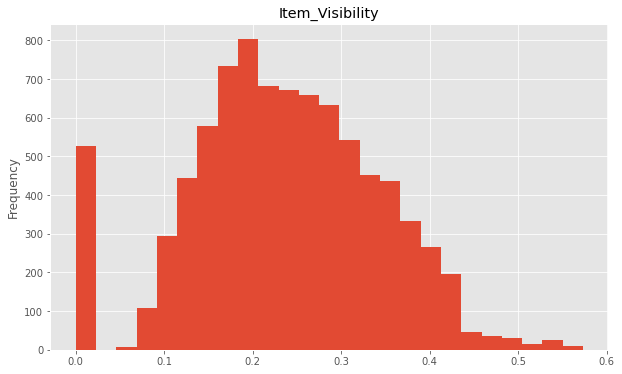

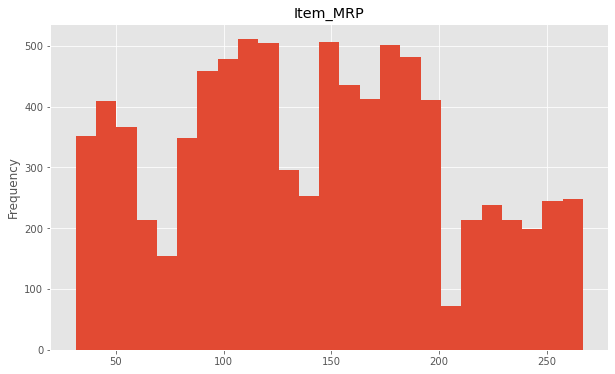

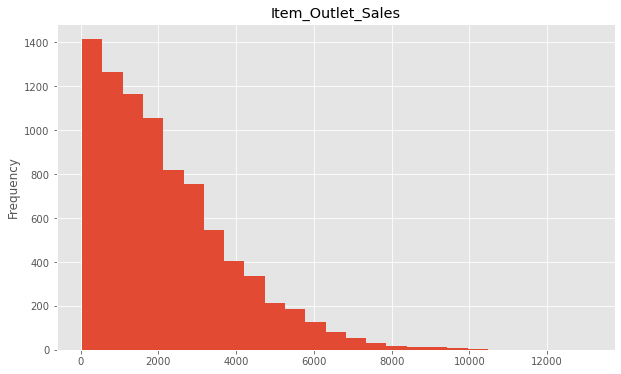

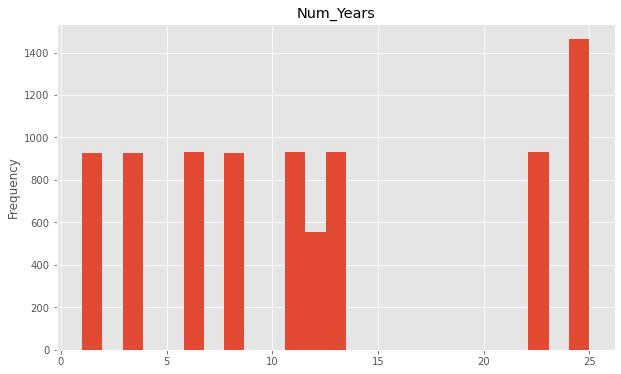

In [24]:
for feature in numerical:
    plt.figure(figsize=(10,6))
    df[feature].plot(kind="hist", title=feature,bins=25)

In [25]:
X = df[categorical+['Item_Visibility', 'Item_MRP']]

In [26]:
X.head()

,Item_Fat_Content,Outlet_Location_Type,Outlet_Type,Item_Visibility,Item_MRP
0,Low Fat,Tier 1,Supermarket Type1,0.126678,249.8092
1,Regular,Tier 3,Supermarket Type2,0.138846,48.2692
2,Low Fat,Tier 1,Supermarket Type1,0.129461,141.6180
3,Regular,Tier 3,Grocery Store,0.000000,182.0950
4,Low Fat,Tier 3,Supermarket Type1,0.000000,53.8614


In [27]:
X = pd.concat([pd.get_dummies(X[categorical],drop_first=True),X[['Item_Visibility', 'Item_MRP']]],axis=1)

In [28]:
X.head()

,Item_Fat_Content_Regular,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Visibility,Item_MRP
0,0,0,0,1,0,0,0.126678,249.8092
1,1,0,1,0,1,0,0.138846,48.2692
2,0,0,0,1,0,0,0.129461,141.6180
3,1,0,1,0,0,0,0.000000,182.0950
4,0,0,1,1,0,0,0.000000,53.8614


In [29]:
X =  X[X.columns.difference(["Outlet_Location_Type_Tier 3"])]

In [30]:
X.head()

,Item_Fat_Content_Regular,Item_MRP,Item_Visibility,Outlet_Location_Type_Tier 2,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0,249.8092,0.126678,0,1,0,0
1,1,48.2692,0.138846,0,0,1,0
2,0,141.6180,0.129461,0,1,0,0
3,1,182.0950,0.000000,0,0,0,0
4,0,53.8614,0.000000,0,1,0,0


In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.concat([pd.Series([variance_inflation_factor(X.values,i) for i in range(len(X.columns))]),pd.Series(X.columns)],axis=1).sort_values(by=0)

,0,1
6,1.414530,Outlet_Type_Supermarket Type3
5,1.422961,Outlet_Type_Supermarket Type2
0,1.523666,Item_Fat_Content_Regular
3,1.997575,Outlet_Location_Type_Tier 2
2,3.835598,Item_Visibility
4,4.529080,Outlet_Type_Supermarket Type1
1,4.690520,Item_MRP


In [32]:
sc =  StandardScaler()

In [33]:
X_trans = sc.fit_transform(X)

In [34]:
## Y variable

In [35]:
Y = df["Item_Outlet_Sales"]

In [36]:
# Testing normality
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test

In [37]:
# Its not normally Distributed
normaltest(Y)

NormaltestResult(statistic=1591.791909986951, pvalue=0.0)

In [38]:
## Transformations Log, Square Root, BoxCox

<AxesSubplot:>

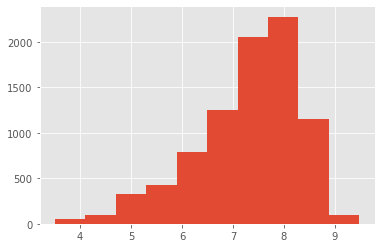

In [39]:
np.log(Y).hist()

In [40]:
# Still its not normally distributed
normaltest(np.log(Y))

NormaltestResult(statistic=909.9175805253095, pvalue=2.5936292512188597e-198)

<AxesSubplot:>

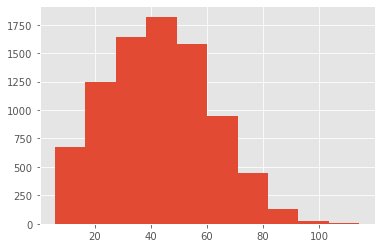

In [41]:
np.sqrt(Y).hist()

In [42]:
# Its still not Normal distribution
normaltest(np.sqrt(Y))

NormaltestResult(statistic=198.24268773011596, pvalue=8.95668541048834e-44)

In [43]:
# BoxCox Transformation

In [44]:
from scipy.stats import boxcox

In [45]:
bc_results = boxcox(Y)
bc_y = bc_results[0]
lam = bc_results[1]

In [46]:
bc_y

array([47.00788505, 20.95829445, 37.96489323, ..., 30.71278953,
       36.19502607, 25.92628684])

(array([ 283.,  736., 1160., 1501., 1810., 1635.,  942.,  383.,   65.,
           8.]),
 array([ 6.83618715, 13.56796569, 20.29974424, 27.03152278, 33.76330132,
        40.49507986, 47.2268584 , 53.95863694, 60.69041549, 67.42219403,
        74.15397257]),
 <BarContainer object of 10 artists>)

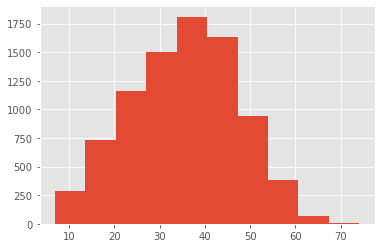

In [47]:
plt.hist(bc_y)

In [48]:
normaltest(bc_y)

NormaltestResult(statistic=207.8732183960798, pvalue=7.25945734144925e-46)

In [49]:
Y =  (np.log(df["Item_Outlet_Sales"]))
#Y = bc_y

In [50]:
X_train,X_test,Y_train,Y_test = train_test_split(X_trans,Y,test_size=0.2,random_state=123)

In [51]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()

In [52]:
regr.fit(X_train,Y_train)

LinearRegression()

In [53]:
regr.coef_

array([ 0.00311379,  0.51808525, -0.00485205,  0.00841234,  0.92428003,
        0.54885126,  0.77252758])

In [54]:
Y_hat = regr.predict(X_test)

In [55]:
Y_hat

array([6.69898063, 5.76503107, 7.91228275, ..., 5.86807799, 8.43429699,
       7.59583318])

In [56]:
Y_test

4532    6.172485
186     6.488917
7557    6.858664
6308    6.538285
7297    8.420115
          ...   
3045    7.707259
629     7.402775
746     6.290268
2661    7.137566
6153    7.634003
Name: Item_Outlet_Sales, Length: 1705, dtype: float64

In [57]:
print("MAPE: ", np.mean(np.abs(Y_hat-Y_test)/Y_test))

MAPE:  0.06113366462610251


In [58]:
importance = pd.DataFrame([pd.Series(regr.coef_),pd.Series(X.columns)]).T.sort_values(by = 0,ascending=False)
importance.columns= ["coef","column"]
importance.set_index("column",inplace=True)

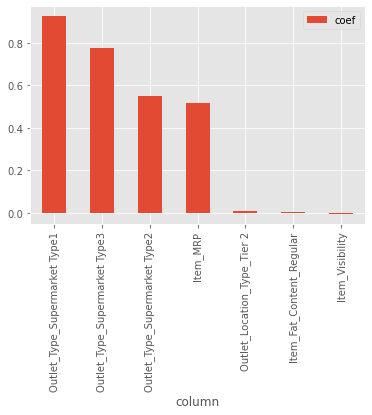

In [59]:
importance.plot(kind="bar")
plt.savefig("summary/importance.jpeg",bbox_inches='tight', dpi=150)

In [60]:
from sklearn.metrics import r2_score
r2_score(Y_hat,Y_test)

0.6353600675076763

## Polymnomial 

#### Testing for best polynomial degree

In [61]:
degrees = range(1,7)

In [62]:
kf = KFold(shuffle = True,random_state=123,n_splits=3)
kf

KFold(n_splits=3, random_state=123, shuffle=True)

In [63]:
for train_indices, test_indices in kf.split(X_test):
    print("train_indices", len(train_indices))
    print("test_indices", len(test_indices) )

train_indices 1136
test_indices 569
train_indices 1137
test_indices 568
train_indices 1137
test_indices 568


In [64]:
for degree in degrees:
    Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(include_bias=False,degree=degree)), ('model',LinearRegression())]
    estimator = Pipeline(Input)
    predictions = cross_val_predict(estimator, X_train, Y_train, cv=kf)
    print("Degree: ",degree,"\n", "R^2: ", r2_score(predictions,Y_train))

Degree:  1 
 R^2:  0.6020845400074839
Degree:  2 
 R^2:  0.6366674588773278
Degree:  3 
 R^2:  0.641723821080691
Degree:  4 
 R^2:  0.6398275461147434
Degree:  5 
 R^2:  0.6380933974936419
Degree:  6 
 R^2:  0.63328344379722


In [65]:
# Bets estimator is for polynomial of degree 3
Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(include_bias=False,degree=3)), ('model',LinearRegression())]
estimator = Pipeline(Input)
estimator.fit(X_train,Y_train)
y_hat_poly = estimator.predict(X_test)

In [66]:
print("MAPE: ", np.mean(np.abs(y_hat_poly-Y_test)/Y_test))

MAPE:  0.05896382222343316


## Ridge

In [67]:
kf = KFold(shuffle=True, random_state=123, n_splits=3)

In [68]:
### Ridge
lr = LinearRegression()
rr = Ridge()
s = StandardScaler()
pf = PolynomialFeatures()

In [69]:
estimator = [("Scaler",s),("Polynomial",PolynomialFeatures()),("Ridge",rr)]
estimator = Pipeline(estimator)

In [70]:
params = { 'Polynomial__degree': [1, 2, 3,4,5,6],
    'Ridge__alpha': np.geomspace(4, 20, 30)}

In [71]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator,params,cv=kf)

In [72]:
grid

GridSearchCV(cv=KFold(n_splits=3, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('Polynomial', PolynomialFeatures()),
                                       ('Ridge', Ridge())]),
             param_grid={'Polynomial__degree': [1, 2, 3, 4, 5, 6],
                         'Ridge__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [73]:
grid.fit(X_train,Y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('Polynomial', PolynomialFeatures()),
                                       ('Ridge', Ridge())]),
             param_grid={'Polynomial__degree': [1, 2, 3, 4, 5, 6],
                         'Ridge__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [74]:
grid.best_score_

0.7339526462337732

In [75]:
grid.best_params_

{'Polynomial__degree': 2, 'Ridge__alpha': 9.720724044870641}

In [76]:
## Using these best parameters to form a right model for predictions

In [77]:
Input =  [("Scaler",s),("Polynomial",PolynomialFeatures(degree=2)),("Ridge",Ridge(alpha=9.720724044870641))]
model = Pipeline(Input)

In [78]:
model.fit(X_train,Y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('Polynomial', PolynomialFeatures()),
                ('Ridge', Ridge(alpha=9.720724044870641))])

In [79]:
y_hat_ridge = model.predict(X_test)

In [80]:
print("MAPE: ", np.mean(np.abs(y_hat_ridge-Y_test)/Y_test))

MAPE:  0.058946237724968514


## Lasso

In [81]:
estimator = [("Scaler",s),("Polynomial",PolynomialFeatures(degree=2)),("Lasso",Lasso(max_iter=5e4))]
estimator = Pipeline(estimator)

In [82]:
params = {
    'Lasso__alpha': np.array([1e-5, 5e-5, 0.0001, 0.0005])}

In [83]:
grid = GridSearchCV(estimator,params,cv=kf)

In [84]:
grid.fit(X_train,Y_train)

F:\1_Softwares_Installed\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.406097808047662, tolerance: 0.47622852284446326
  model = cd_fast.enet_coordinate_descent(
F:\1_Softwares_Installed\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4832467745136455, tolerance: 0.45639838024870105
  model = cd_fast.enet_coordinate_descent(
F:\1_Softwares_Installed\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.991160160903291, tolerance: 0.4659716214296032
  model = cd_fast.enet_coordinate_descent(
F:\1_Softwares_Installed\Anaconda\lib\site-packages\sklearn\linear_model\_co

GridSearchCV(cv=KFold(n_splits=3, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('Polynomial', PolynomialFeatures()),
                                       ('Lasso', Lasso(max_iter=50000.0))]),
             param_grid={'Lasso__alpha': array([1.e-05, 5.e-05, 1.e-04, 5.e-04])})

In [85]:
grid.best_score_

0.7341760653821833

In [86]:
grid.best_params_

{'Lasso__alpha': 0.0005}

In [87]:
estimator = [("Scaler",s),("Polynomial",PolynomialFeatures(degree=2)),("Lasso",Lasso(max_iter=0.0005))]
estimator = Pipeline(estimator)
estimator.fit(X_train,Y_train)

F:\1_Softwares_Installed\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0001, tolerance: 0.6993067307035393
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('Scaler', StandardScaler()),
                ('Polynomial', PolynomialFeatures()),
                ('Lasso', Lasso(max_iter=0.0005))])

In [88]:
y_hat = estimator.predict(X_test)

In [89]:
print("MAPE: ", np.mean(np.abs(y_hat-Y_test)/Y_test))

MAPE:  0.1242814236357545
